In [13]:
import copy

import torch
from basic_transformer import QuantileTransformer, QuantileConvDecoderOnlyTransformer
import attention as ATTN

import numpy as np
import matplotlib.pyplot as plt
from synthetic_datasets import SineSyntheticDataset

(torch.Size([50, 1]),
 torch.Size([50, 1]),
 torch.Size([10, 1]),
 torch.Size([10, 1]))

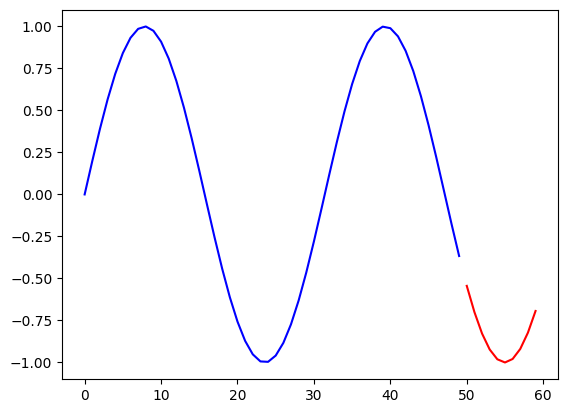

In [101]:
dataset = SineSyntheticDataset(
    len_timeseries=5000,
    seq_len=50,
    shift=10,
    alpha=0.2
)

src_x, src_y, tgt_x, tgt_y = dataset[0]

plt.plot(src_x.numpy(), src_y.numpy(), 'b')
plt.plot(tgt_x.numpy(), tgt_y.numpy(), 'r')

src_x.shape, src_y.shape, tgt_x.shape, tgt_y.shape

In [102]:
from torch.utils.data import DataLoader

train_set, test_set, val_set = torch.utils.data.random_split(dataset, (0.8, 0.1, 0.1))

train_dl = DataLoader(train_set, batch_size=32, shuffle=True, drop_last=True)
test_dl = DataLoader(test_set, batch_size=64, shuffle=False, drop_last=True)
val_dl = DataLoader(val_set, batch_size=64, shuffle=True, drop_last=True)

len(train_set), len(val_set), len(test_set), len(train_dl), len(val_dl), len(test_dl)

(3952, 494, 494, 123, 7, 7)

In [103]:
def train_step(model, criterion, train_dataloader, optimizer, mask, device):
    model.train()
    train_loss = torch.zeros_like(criterion.q)
    n = 0
    mask = mask.to(device)
    for sample in train_dataloader:
        src_X, src_fX, tgt_X, tgt_fX = (v.to(device) for v in sample)
        
        out = model(src_X, src_fX, mask)
        p_loss = criterion(out[:, -tgt_X.shape[1]:], tgt_fX)

        optimizer.zero_grad()
        p_loss.sum().backward()
        optimizer.step()
        
        train_loss += p_loss * src_X.shape[0]
        n += src_X.shape[0]

    return train_loss / n

def val_step(model, criterion, val_dataloader, mask, device):
    model.eval()
    val_loss = torch.zeros_like(criterion.q)
    n = 0
    mask = mask.to(device)
    with torch.no_grad():
        for sample in val_dataloader:
            src_X, src_fX, tgt_X, tgt_fX = (v.to(device) for v in sample)
            
            out = model(src_X, src_fX, mask)
            p_loss = criterion(out[:, -tgt_X.shape[1]:], tgt_fX)
            
            val_loss += p_loss * src_X.shape[0]
            n += src_X.shape[0]

    return val_loss / n

In [104]:
lr = 1e-2
EPOCHS = 100
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
patience = 10

In [105]:
model = QuantileTransformer(
    d_in=2,
    n_quantiles=3,
    emb_size=20,
    n_heads=4,
    n_hidden=32,
    ffn_n_hidden=10,
    num_layers=1,
    _attention=ATTN.DotProductAttention(),
    norm_first=True
).to(DEVICE)

x = torch.randn(32, 192, 1).to(DEVICE)
y = torch.randn(32, 192, 1).to(DEVICE)

model(x, y).shape, model.transformer_blocks[0].mha.attn_weights.shape

(torch.Size([32, 192, 3]), torch.Size([32, 4, 192, 192]))

In [106]:
from criterions import QuantileLoss
import argparse

train_history = []
val_history = []

config = argparse.Namespace()
config.quantiles = [0.1, 0.5, 0.9]
criterion = QuantileLoss(config).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)

best_val_loss = float('inf')
early_stopping_c = 0
best_model = None

for epoch in range(EPOCHS):

    train_loss = train_step(model, criterion, train_dl, optimizer, dataset.mask, DEVICE)
    train_history.append({'p10': train_loss[0].item(), 'p50': train_loss[1].item(), 'p90': train_loss[2].item()})

    val_loss = val_step(model, criterion, val_dl, dataset.mask, DEVICE)
    val_history.append({'p10': val_loss[0].item(), 'p50': val_loss[1].item(), 'p90': val_loss[2].item()})
    
    print(f"{epoch=}\t{train_history[-1]}\t{val_history[-1]}")
    
    val_loss_sum = val_loss.sum().item()
    scheduler.step(val_loss_sum)
    
    if val_loss_sum < best_val_loss:
        best_val_loss = val_loss_sum
        early_stopping_c = 0
        best_model = copy.deepcopy(model)
    else:
        early_stopping_c += 1
        
    if early_stopping_c > patience: break

test_loss = val_step(best_model, criterion, test_dl, dataset.mask, DEVICE)
test_loss

epoch=0	{'p10': 0.11210256814956665, 'p50': 0.32247689366340637, 'p90': 0.11030075699090958}	{'p10': 0.1004122719168663, 'p50': 0.3213426470756531, 'p90': 0.09839515388011932}
epoch=1	{'p10': 0.10108231008052826, 'p50': 0.32007908821105957, 'p90': 0.10086171329021454}	{'p10': 0.09966986626386642, 'p50': 0.32042109966278076, 'p90': 0.09792491793632507}
epoch=2	{'p10': 0.0999780148267746, 'p50': 0.31910961866378784, 'p90': 0.09968499839305878}	{'p10': 0.09950762242078781, 'p50': 0.3181864023208618, 'p90': 0.09726764261722565}
epoch=3	{'p10': 0.09907031804323196, 'p50': 0.31871333718299866, 'p90': 0.099481001496315}	{'p10': 0.10004273056983948, 'p50': 0.3197651505470276, 'p90': 0.0967772826552391}
epoch=4	{'p10': 0.0988781601190567, 'p50': 0.31844112277030945, 'p90': 0.09903725981712341}	{'p10': 0.10119911283254623, 'p50': 0.3191121220588684, 'p90': 0.09640882164239883}
epoch=5	{'p10': 0.0985422432422638, 'p50': 0.318587988615036, 'p90': 0.0989132672548294}	{'p10': 0.0995846763253212, 'p5

tensor([0.0690, 0.1610, 0.0600], device='cuda:0')

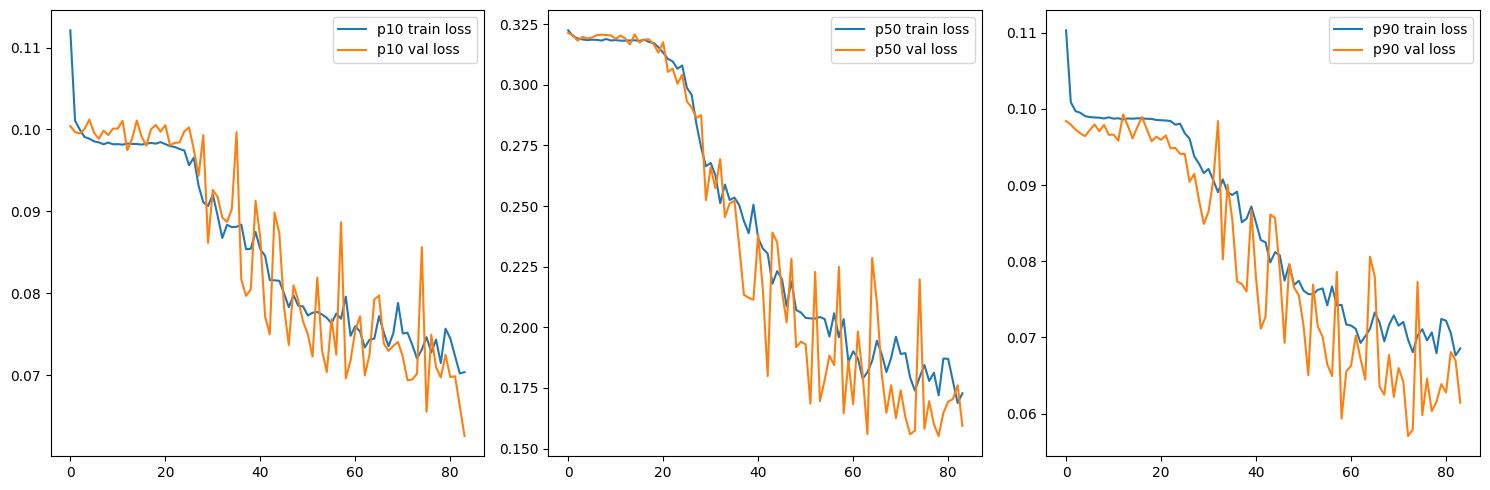

In [107]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5), sharex=True)

p10_train = [x['p10'] for x in train_history]
p50_train = [x['p50'] for x in train_history]
p90_train = [x['p90'] for x in train_history]

p10_val = [x['p10'] for x in val_history]
p50_val = [x['p50'] for x in val_history]
p90_val = [x['p90'] for x in val_history]

ax1.plot(p10_train, label='p10 train loss')
ax1.plot(p10_val, label='p10 val loss')
ax1.legend()

ax2.plot(p50_train, label='p50 train loss')
ax2.plot(p50_val, label='p50 val loss')
ax2.legend()

ax3.plot(p90_train, label='p90 train loss')
ax3.plot(p90_val, label='p90 val loss')
ax3.legend()

plt.tight_layout()

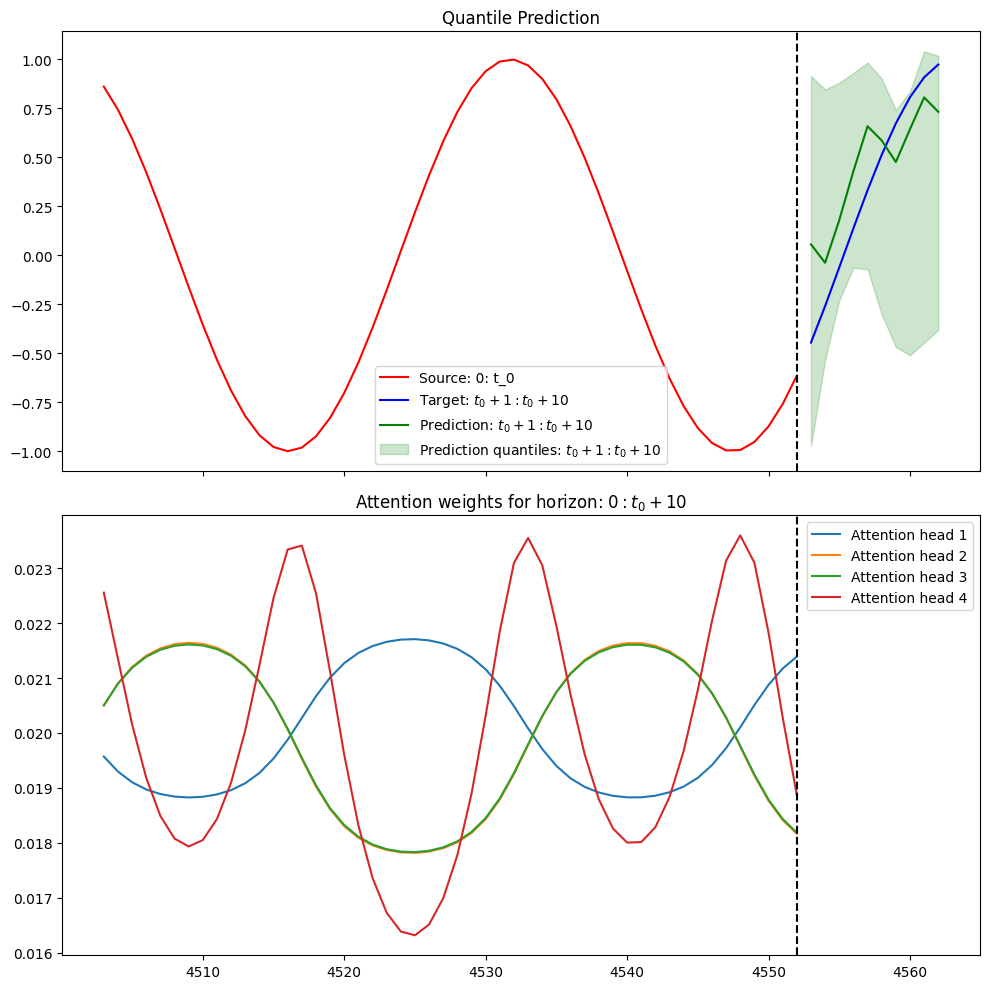

In [108]:
idx = 0

with torch.no_grad():
    src_X, src_fX, tgt_X, tgt_fX = test_set[0]
    
    out = best_model(src_X.unsqueeze(0).to(DEVICE), src_fX.unsqueeze(0).to(DEVICE), dataset.mask.to(DEVICE))
    pred = out[:, -tgt_X.shape[0]:].squeeze().cpu()
    
    num_horizons = tgt_X.shape[0]
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10), sharex=True)

    ax1.plot(src_X, src_fX, '-r', label="Source: 0: t_0")
    ax1.plot(tgt_X, tgt_fX, '-b', label=f"Target: $t_0+1: t_0+{num_horizons}$")
    ax1.plot(tgt_X, pred[:, 1], '-g', label=f"Prediction: $t_0+1: t_0+{num_horizons}$")
    ax1.fill_between(tgt_X.squeeze(), pred[:, 0], pred[:, 2], alpha=0.2, color='green', label=f"Prediction quantiles: $t_0+1: t_0+{num_horizons}$")
    ax1.axvline(src_X[-1, 0], linestyle='--', color='k')
    ax1.legend()
    
    attn_w = model.transformer_blocks[0].mha.attn_weights[0]
    for j, attn in enumerate(attn_w):
        ax2.plot(src_X, attn[-1].cpu(), label=f"Attention head {j + 1}")
    ax2.axvline(src_X[-1, 0], linestyle='--', color='k')
    ax2.legend()

    ax1.set_title("Quantile Prediction")
    ax2.set_title(f"Attention weights for horizon: $0: t_0+{num_horizons}$")
    
    plt.tight_layout()

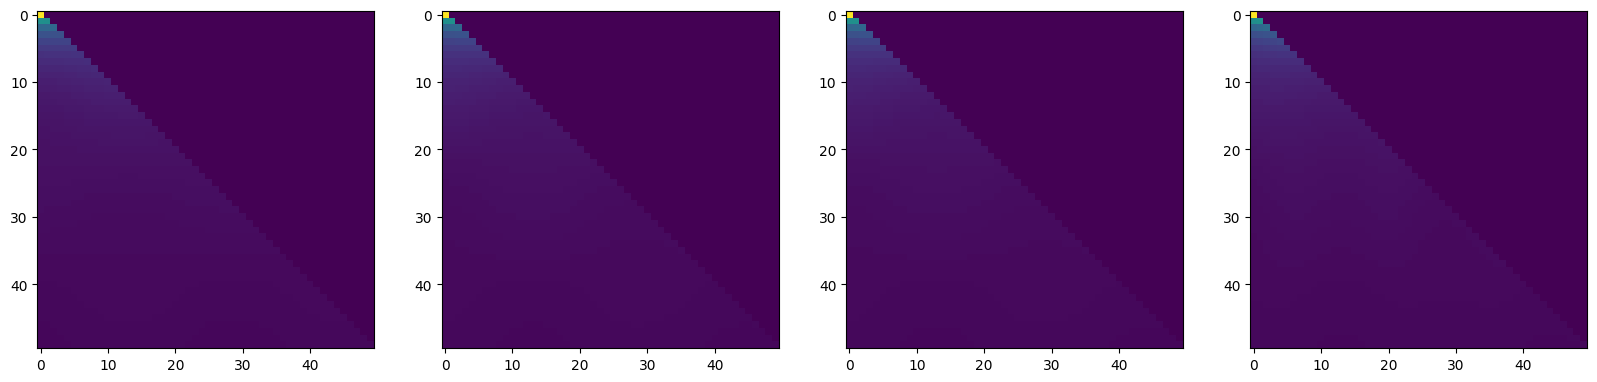

In [109]:
attn_w = best_model.transformer_blocks[0].mha.attn_weights[0].cpu()

fig, axes = plt.subplots(1, attn_w.shape[0], figsize=(5*attn_w.shape[0], 5))

_min, _max = attn_w.min(), attn_w.max()

for ax, attn in zip(axes, attn_w):
    ax.imshow(attn, vmin = _min, vmax = _max)
    ax.autoscale(False)

In [93]:
_min, _max

(tensor(0.), tensor(1.))